In [1]:
magma_dir = '/home/marco/epfl/magma/'

#### AWS

In [ ]:
magma_dir = '/home/ubuntu/magma/'
bucket_dir = '/home/ubuntu/s3/'
transformers_dir = '/home/ubuntu/transformers/'
cache_dir = bucket_dir+'.cache/'

### **Config**

In [2]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
MODEL = 'bart'
MODELS = {}

In [4]:
# Dataset path
data_dir = magma_dir + 'datasets/karger_books_para_rouge/'+MODEL+'/'

# Output path
OUTPUT_PATH = magma_dir+'summarization/assign_bullets_para_rouge/'+MODEL+'/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

#### AWS

In [ ]:
data_dir = bucket_dir + 'datasets/karger_books_para_rouge/'+MODEL+'/'

### **Init**

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
tqdm.pandas()

### **Function Definition**

##### Import Model and Tok

In [13]:
def import_model_tok(model_name_or_path, verbose=False):
    global MODELS

    if model_name_or_path in MODELS.keys():
        if verbose : print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    if verbose : print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    if verbose : print(model.config)
    MODELS[model_name_or_path] = model, tokenizer
    if verbose : print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Print Examples

In [7]:
def print_examples(model_name_list, df, n_examples=10):
    
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():
        print(idx)
        print(fill(row.text, 100))
        print()
        for model_name in model_name_list:
            model, tokenizer = import_model_tok(model_name)
            model = model.to(device)
            
            summ_enc = model.generate(
                tokenizer.encode(row.text, return_tensors='pt').to(device),
                min_length = config.ONE_BULLET_MIN_LEN,
                max_length = config.ONE_BULLET_MAX_LEN,
                length_penalty = config.LENGTH_PENALTY,
                num_beams = config.NUM_BEAMS,
                no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
                early_stopping = True)[0]
            summ_num_tok = len(summ_enc)
            summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

            print('Prediction\n%s (%d tok):\n'%(model_name, summ_num_tok))
            print(fill(summ, 100))
            print()
            
        print('Reference:')
        print(fill(row.bullets, 100))
        print()
        print(''.join(['#']*100))
        print()

##### Plot Evaluation

In [8]:
def plot_evaluation_bullet_by_bullet(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '_bullet_by_bullet.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+3))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks[:-2]+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))
        
    box_plt_list.append(
        plt.boxplot(
        df['st_cosine_sim'].tolist(),
        positions=[xticks[-2]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))
    
    box_plt_list.append(
        plt.boxplot(
        df['w2v_cosine_sim'].tolist(),
        positions=[xticks[-1]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))

    for i, bp in enumerate(box_plt_list[:-2]):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES+['ST Cosine', 'W2V Cosine'], fontsize='x-large')
    plt.show()

In [9]:
def plot_evaluation_grouping_bullets(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '_grouped.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+3))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks[:-2]+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))
    
    box_plt_list.append(
        plt.boxplot(
        df['st_cosine_sim'].tolist(),
        positions=[xticks[-2]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))
    
    box_plt_list.append(
        plt.boxplot(
        df['w2v_cosine_sim'].tolist(),
        positions=[xticks[-1]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))

    for i, bp in enumerate(box_plt_list[:-2]):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES+['ST Cosine', 'W2V Cosine'], fontsize='x-large')
    plt.show()

## **Karger Books Para**

In [10]:
df_train = pd.read_csv(data_dir + 'train.csv').set_index(['book', 'chapter'])
df_val = pd.read_csv(data_dir + 'val.csv').set_index(['book', 'chapter'])
df_test = pd.read_csv(data_dir + 'test.csv').set_index(['book', 'chapter'])

### **Print and Summarization**

##### Print Train Examples

In [14]:
print_examples([
    'sshleifer/distilbart-cnn-12-6'],
    df_train)

[+] model already present in cache

(9781912776696, 'hh-5')
Kaplan-Meier survival curves are often used to compare the data between two groups of subjects.
Figure 2.2 shows Kaplan-Meier curves for OS in a randomized study of patients with human epidermal
growth factor receptor 2 (HER2)-positive metastatic breast cancer treated either with or without
trastuzumab. The Kaplan-Meier curve steps down at time points at which deaths occur, while censored
observations are denoted by notches on the curve. In this study, the follow-up period ranged from 3
months to 74 months. The Kaplan-Meier curve plots the probability of being event free over time,
with these probabilities being estimated from the data in the study. Note that the curve for
patients who received trastuzumab is consistently above the curve for those who did not receive
trastuzumab, indicating a higher survival probability in that group.

Prediction (47 tokens):
 Figure 2.2 shows Kaplan-Meier curves for OS in a randomized study o

(9781910797662, 'ch03')
Anorexia, nausea, weight loss and malaise may result from renal failure due to bilateral ureteric
obstruction, or from the systemic effects of the tumor itself. Bone pain or pathological fractures
may result from skeletal metastases (Figure 3.3); the pain is unrelieved by rest and can be severe.
Anemia and hypercalcemia may occur as metabolic complications of advanced disease; leukocytosis is
occasionally associated with the elaboration of colony-stimulating factors by the tumor. Headache or
disordered thought processes are uncommon as a presenting feature but may indicate underlying brain
metastases or carcinomatous meningitis.

Prediction (57 tokens):
 Anorexia, nausea, weight loss and malaise may result from renal failure due to bilateral ureteric
obstruction. Bone pain or pathological fractures may result from skeletal metastases. Anemia and
hypercalcemia may occur as metabolic complications of advanced disease.

Reference:
Recurrent infections may indicate 

##### Print Val Examples

In [16]:
print_examples([
    'sshleifer/distilbart-cnn-12-6'],
    df_val)

[+] model already present in cache

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction (46 tokens):
 M

(9781910797815, 'chp9')
There are no specific diagnostic criteria for MPN-BP. The principal criterion is the same as for de
novo acute myeloid leukemia (AML): more than 20% blasts in bone marrow or peripheral blood.
Persistence is also important if only peripheral blood blasts are considered. Importantly,
acceleration or progression of myelofibrosis is usually apparent before the development of overt
leukemia. Signs of this include.

Prediction (47 tokens):
 There are no specific diagnostic criteria for MPN-BP. The principal criterion is the same as for de
novo acute myeloid leukemia (AML): more than 20% blasts in bone marrow or peripheral blood.

Reference:
Signs of accelerating myelofibrosis may precede the development of overt leukemia.

####################################################################################################

(9783318068207, 'hh-7')
Melanoma is a highly mutated malignancy, with mutations documented in all subtypes (Table 5.3)., The
KIT mutation is associ

##### Print Test Examples

In [18]:
print_examples([
    'sshleifer/distilbart-cnn-12-6'],
    df_test)

[+] model already present in cache

(9781908541277, 'ch_8')
After a hiatus of nearly 20 years, 16 new AEDs and two devices - the vagus nerve stimulator and deep
brain stimulator - have received licenses for the adjunctive treatment of refractory epilepsy, the
last so far only in Europe. Gabapentin (GBP), lacosamide (LCM), LTG, levetiracetam (LEV),
oxcarbazepine (OXC), pregabalin (PGB), tiagabine (TGB), TPM and zonisamide (ZNS) are widely
available for partial seizures. Rufinamide (RFN) has been licensed in Europe and the USA for
adjunctive treatment of seizures in Lennox-Gastaut syndrome. Eslicarbazepine acetate (ESL) is
licensed in Europe as adjunctive treatment for partial seizures with or without secondary
generalization. Retigabine (RTG; ezogabine in the USA) and perampanel (PER) have recently been
approved for use in Europe and the USA for the same indication. After 20 years of global experience,
vigabatrin (VGB) has been approved in the USA for the treatment of infantile spasms a

(9781910797211, 'ch04')
The study started in 2000 with a median follow-up of 3 years and maximum of 7 years. During this
time the dopamine agonists varied, including ergot agonists that are no longer in widespread use.
The randomization to levodopa or alternative regimens was at the discretion of the clinician and a
large part of the study was conducted in centers for the care of the elderly. The findings suggest
relatively small but persistent benefits of starting therapy with levodopa rather than the listed
alternatives. Interestingly, initial treatment with a MAOB inhibitor appeared to be at least as
effective as treatment with a dopamine agonist. Patients assigned to the levodopa arm scored, on
average, 1.8 points (95% CI 0.5-3.0) higher on the Parkinson's Disease Questionnaire-39 (PDQ-39)
mobility subscale than those assigned to levodopa-sparing therapies; however, the effects on non-
motor aspects of the scale are unclear. A cost-utility analysis of the study will be reported
sep

##### Summarize Test

In [14]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary'] = summs
    
    df.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [15]:
df_test = summarize('sshleifer/distilbart-cnn-12-6', df_test, 10)

100%|██████████| 25/25 [14:59<00:00, 35.97s/it]


### **Evaluation**

In [16]:
from datasets import load_metric

metric = load_metric("rouge")

from sentence_transformers import SentenceTransformer

sentence_distilroberta = SentenceTransformer('paraphrase-distilroberta-base-v1')

import gensim

#### Evaluate summaries bullet by bullet

In [17]:
def evaluate_model_bullet_by_bullet(model_name_or_path):
    df_eval = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '.csv').set_index(['book', 'chapter'])
    
    rouge_res =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)
    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf] =\
                rouge_res.map(lambda score: 100*score[r][0][i])
    
    cosine_sim = lambda a, b: (np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b)))
    df_eval['st_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim(
            sentence_distilroberta.encode(row[1]),
            sentence_distilroberta.encode(row[0])), axis=1)
    
    def cosine_sim_w2v(s, b):
        s = gensim.utils.simple_preprocess(s, deacc=True)
        b = gensim.utils.simple_preprocess(b, deacc=True)
        corpus = [s, b]
        w2v = gensim.models.Word2Vec(
            corpus,
            min_count=1,
            sg=1,
            seed = config.SEED)
        s_embed = np.mean([w2v.wv[word] for word in s], axis=0)
        b_embed = np.mean([w2v.wv[word] for word in b], axis=0)
        return cosine_sim(s_embed, b_embed)
        
    df_eval['w2v_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim_w2v(row[1], row[0]), axis=1)
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'_bullet_by_bullet.csv')
    
    return df_eval

In [18]:
evaluate_model_bullet_by_bullet('sshleifer/distilbart-cnn-12-6')

bullets  \
book          chapter                                                      
9781910797631 chp6     The treatment rather than the prevention of de...   
              chp6     For milder forms of depression, self-help, rel...   
              chp6     There are a range of treatments that may be ef...   
              chp6     Depression is complex, and understanding and h...   
              chp6     Selective serotonin-reuptake inhibitor antidep...   
...                                                                  ...   
9781908541680 ch_4     Obesity significantly affects cardiometabolic ...   
              ch_4     The metabolic syndrome defines the clustering ...   
              ch_4     Weight loss rapidly and effectively reduces ca...   
              ch_4     Type 2 diabetes mellitus is the comorbidity mo...   
              ch_4     Lipid disorders and hypertension are exacerbat...   

                                                                    text  \
book          chapter                                                      
9781910797631 chp6     Universal versus selected prevention approache...   
              chp6     Overall, findings from trials conducted in a r...   
              chp6     The attention given to improving recognition o...   
              chp6     Psychological approaches using the computer an...   
              chp6     Regimen changes. Increasing the dose may be be...   
...                                                                  ...   
9781908541680 ch_4     Definition of the metabolic syndrome is of val...   
              ch_4     Definition of the metabolic syndrome is of val...   
              ch_4     Is weight loss always beneficial? Obesity, par...   
              ch_4     The lag phase between the onset of uncomplicat...   
              ch_4     Mechanism of obesity-related hypertension. Inc...   

                       num_bulls  \
book          chapter              
9781910797631 chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
...                          ...   
9781908541680 ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   

                                                                 summary  \
book          chapter                                                      
9781910797631 chp6      A systematic review has identified good evide...   
              chp6      Preventive interventions may reduce the incid...   
              chp6      A central issue in relation to depression man...   
              chp6      Internet-based CBT programs make use of the s...   
              chp6      Increasing the dose may be beneficial, but th...   
...                                                                  ...   
9781908541680 ch_4      The aim of management is to tackle the syndro...   
              ch_4      The aim of management is to tackle the syndro...   
              ch_4      Obesity, particularly when severe, is associa...   
              ch_4      The lag phase between the onset of uncomplica...   
              ch_4      Increased renal sodium reabsorption and blood...   

                       rouge1_precision  rouge1_recall  rouge1_fmeasure  \
book          chapter                                                     
9781910797631 chp6            18.604651      19.047619        18.823529   
              chp6            18.750000      12.500000        15.000000   
              chp6            29.729730      34.375000        31.884058   
              chp6            20.689655      24.000000        22.222222   
              chp6             9.756098      16.000000        12.121212   
...                                 ...            ...              ...   
9781908541680 ch_4           

#### Evaluate summaries grouping bullets

In [19]:
def evaluate_model_grouping_bullets(model_name_or_path):
    df_eval = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '.csv').set_index(['book', 'chapter'])
    
    df_eval = df_eval.groupby(['book', 'chapter'], sort=False).agg({
        'text': lambda t: ' '.join(list(t)),
        'bullets': lambda b: ' '.join(list(b)),
        'summary': lambda s: ' '.join(list(s))})
    
    rouge_res =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)
    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf] =\
                rouge_res.map(lambda score: 100*score[r][0][i])
            
    cosine_sim = lambda a, b: (np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b)))
    df_eval['st_cosine_sim'] =\
    df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim(
            sentence_distilroberta.encode(row[1]),
            sentence_distilroberta.encode(row[0])), axis=1)
    
    def cosine_sim_w2v(s, b):
        s = gensim.utils.simple_preprocess(s, deacc=True)
        b = gensim.utils.simple_preprocess(b, deacc=True)
        corpus = [s, b]
        w2v = gensim.models.Word2Vec(
            corpus,
            min_count=1,
            sg=1,
            seed = config.SEED)
        s_embed = np.mean([w2v.wv[word] for word in s], axis=0)
        b_embed = np.mean([w2v.wv[word] for word in b], axis=0)
        return cosine_sim(s_embed, b_embed)
        
    df_eval['w2v_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim_w2v(row[1], row[0]), axis=1)
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'_grouped.csv')
    
    return df_eval

In [20]:
evaluate_model_grouping_bullets('sshleifer/distilbart-cnn-12-6')

,,text,bullets,summary,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure,st_cosine_sim,w2v_cosine_sim
book,chapter,,,,,,,,,,,,,,
9781910797631,chp6,Universal versus selected prevention approache...,The treatment rather than the prevention of de...,A systematic review has identified good evide...,34.065934,36.046512,35.028249,3.867403,4.093567,3.977273,13.186813,13.953488,13.559322,68.411070,84.643918
9781910797426,ch03,Epidemiology and risk factors. Gallstones are ...,The prevalence of gallstones is greater in peo...,Gallstones are a significant cause of morbidi...,44.565217,64.062500,52.564103,25.683060,37.007874,30.322581,30.434783,43.750000,35.897436,82.607192,93.882108
9781908541277,ch_12,Depression is the most prevalent psychiatric c...,Depression and anxiety are common in patients ...,"Depression is under-recognized and, when diag...",23.076923,46.308725,30.803571,5.704698,11.486486,7.623318,10.367893,20.805369,13.839286,68.509585,90.950251
9781910797907,chp6,Red blood cell (RBC) transfusions are frequent...,The decision for transfusion therapy relates t...,There is no set standard with regard to trans...,37.765957,54.198473,44.514107,12.299465,17.692308,14.511041,22.872340,32.824427,26.959248,78.505832,83.678317
9781908541277,ch_8,Dosage. CBZ should be introduced at low doses ...,This wider choice of AEDs permits pharmacologi...,CBZ should be introduced at low doses (100-20...,14.503817,36.538462,20.765027,1.538462,3.921569,2.209945,11.450382,28.846154,16.393443,60.567909,59.094203
9781910797006,ch08,Acute exacerbations of chronic obstructive pul...,Acute exacerbations of COPD are common and pla...,"In the UK, respiratory admissions account for...",19.815668,48.314607,28.104575,5.092593,12.500000,7.236842,11.059908,26.966292,15.686275,59.934384,76.173538
9781910797105,ch06,Morphological findings. MRI studies confirmed ...,People with schizophrenia exhibit gray matter ...,People with schizophrenia exhibit decreased v...,28.125000,78.640777,41.432225,17.073171,48.039216,25.192802,23.263889,65.048544,34.271100,83.765018,94.807494
9783318068207,hh-5,The recent improvements in terms of available ...,Comprehensive genomic profiles offer a complet...,The adoption of broad NGS gene panels may sup...,24.279835,48.360656,32.328767,5.785124,11.570248,7.713499,14.403292,28.688525,19.178082,61.357766,88.070619
9781910797105,ch04,The most straightforward studies in population...,Having a close relative with schizophrenia inc...,"Usually, a series of individuals with schizop...",14.354067,42.253521,21.428571,2.403846,7.142857,3.597122,9.569378,28.169014,14.285714,70.504969,76.647425


#### Plot evaluation bullet by bullet

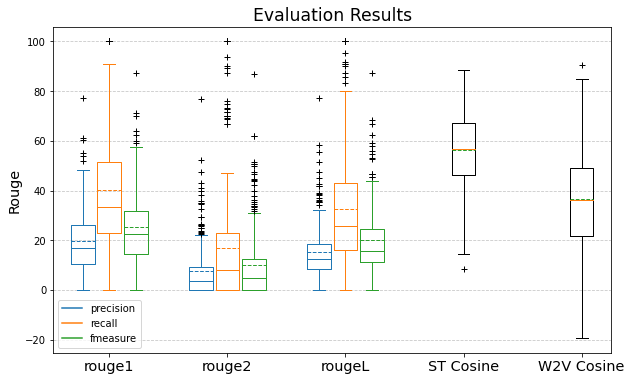

In [21]:
plot_evaluation_bullet_by_bullet('sshleifer/distilbart-cnn-12-6')

#### Plot evaluation grouping bullets

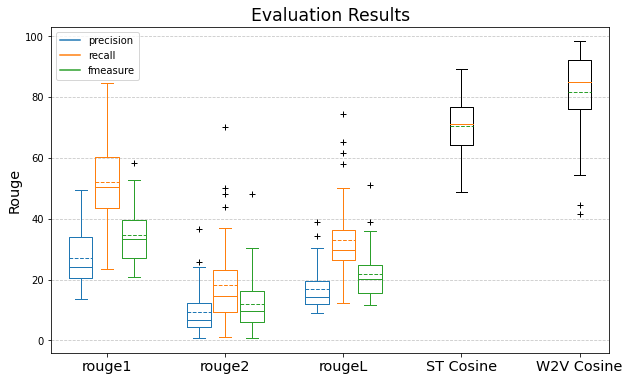

In [22]:
plot_evaluation_grouping_bullets('sshleifer/distilbart-cnn-12-6')